# How Pyro Really Works

## or How to Write Yourself a Probabilistic Programming Framwork
## or Please Try This at Home

Ever wondered how pyro (or probabilistic programming in general) really works? How does it do variational inference, and what is that in the first place? It's conceptually simpler than one might think, because it follows from the combination of a handful of rather simple ideas. In this tutorial we will look at each of them in turn.

## 0. Joint, Marginal, and Conditional Distributions

#### Summary:

- If we have a *joint distribution* ($p(A,B)$),
  we can express *marginal* ($p(A)$) and *conditional distributions* $p(A \mid B)$ based on the joint distribution
- Conversely, joint distributions can always be *factorized* into a product of conditional and marginal distributions
  $$ p(A,B) = p(A \mid B) p(B) $$
- Sampling the variables in some order gives rise to a factorization
  $$ p(x_1, \ldots, x_n) = \prod_i p(x_i \mid x_1, \ldots x_{i-1}) $$
  and describes a *generative process*.

### Basics

Probability distributions may be defined on several random variables (RVs), e.g. $A$, $B$, and $C$. The distribution over all variables $p(A,B,C)$ is called the *joint distribution*, which is normalized such that the sum over all possible RV assignments is 1. (In the continuous case, we integrate instead of summing.)

The *marginal distribution* of a subset of the RVs is obtained from the joint distribution by summing (or integrating) over all remaining variables. for example
$$ p(A) = \sum_B \sum_C p(A,B,C) $$
and
$$ p(A,B) = \sum_C p(A,B,C) $$

A *conditional distribution* is the distribution of some of the RVs given that other RVs are known to have a certain value, e.g. $p(A,B \mid C=c)$.
If the value of the known RV is arbitrary, we write $p(A,B \mid C)$.
If we are only interested in the distribution of some of the unknown RVs, we can again marginalize out the remaining unknown RVs, e.g.
$$ p(A \mid C) = \sum_B p(A, B | C) $$

We can obtain the conditional distribution from the joint distribution by fixing the value of the known RVs ($p(A,B,C=c)$).
Since we now only look at a subset of the RV assignment (e.g. those in which $C=c$), we have to renormalize by the probability to have one of these assignments $p(C=c)$:
$$ p(A,B \mid C=c) = \dfrac{p(A,B,C=c)}{p(C=c)}$$
or more generally
$$ p(A,B \mid C) = \dfrac{p(A,B,C)}{p(C)} $$

### Factorizing a Joint Distribution

From the above section it follows that every joint distribution can be factorized into simpler conditional and marginal distributions.
For example, we can turn the previous equation around and obtain
$$ p(A,B,C) = p(A,B \mid C) p(C) $$

Since $p(A,B \mid C)$ can be understood as another joint distribution (of $A$ and $B$, given $C$), it can be factorized again (given $C$!), e.g.:
$$ p(A,B \mid C) = p(A \mid B,C) p(B \mid C) $$

and consequently
$$ p(A,B,C) = p(A,B \mid C) p(C) = p(A \mid B,C) p(B \mid C) p(C). $$

Note that the order in which we factor out variables doesn't matter, so the following is equivalent:
$$ p(A,B,C) = p(B,C \mid A) p(A) = p(B \mid C,A) p(C \mid A) p(A). $$

We can understand any factorization as an ordering of the RVs when sampling from the joint distribution.
Instead of sampling all of them together, we sample each RV from its conditional distribution, starting with the one that is sampled from its unconditional marginal distribution.
For example, in the first factorization above ($p(A \mid B,C) p(B \mid C) p(C)$, we first sample $C$ from $p(C)$, which doesn't depend on any of the other RVs.
Then, knowing the value $c$ of $C$, we can sample $B$ from $p(B \mid C=c)$, and finally (knowing $B=b$ and $C=c$) we can sample $A$ from $p(A \mid B=b, C=c)$.
Thus we have turned the joint distribution $p(A,B,C)$ into a *generative process* that produces each RV in turn.

### Exercises

1. Given the joint distribution $p(A,B,C,D)$, what is the marginal distribution $p(A,C)$?
1. Given the same joint distribution $p(A,B,C,D)$, what is the conditional distribution $p(A,B | C)$?
   Express it only using the joint distribution.
1. Let $p(X,Y,Z) = p(Z \mid X,Y) p(X) p(Y)$. What is $p(X \mid Y$? What is $p(Y \mid Z, X)$?

## 1. Bayesian Inference

#### Summary

- Bayesian models are defined by a *joint distribution* $p(X,Z)$
  over observed ($X$) and unobserved variables ($Z$).
- Bayesian inference is computing the *posterior distribution* $p(Z \mid X)$.
- Sometimes, the joint distribution is given as factorized into a *likelihood* $p(X \mid Z)$ and a *prior* $p(Z)$.

### Bayesian Models

Bayesian inference builds on the "bayesian" interpretation of probabilities as talking about the plausibility of statements.
BI starts from the assumption that we can define a joint *plausibility distribution* over observed ($X$) and unobserved variables ($Z$): $p(X,Z)$, which assings a plausibility $p(X=x, Z=z)$ to any particular instantiation of $X$ and $Z$.
Doing *inference* means to asses the plausibility of latent variable assignments, given that the observed variables take some (observed) value: $p(Z \mid X=x)$.

#### Example

While the above may sound very abstract, a common situation in which it is useful is when we have a probabilistic model (i.e. a probability distribution) of some data $d$, i.e. a distribution so that we can interpret the data $d$ as sampled from a random variable $D$.
Our distribution over $D$ has some parameters $\theta$, so we can write it as $p_\theta(D)$.
If we change $\theta$, we change the distribution.

Now we want a good value for $\theta$.
Since the distribution is suppose to "model" the data, we want $\theta$ to be chosen such that $D=d$ has a very high probability under $p_\theta$.
In other words, we want to maximize the function $\theta \to p_\theta(D=d)$.
This function is called the *likelihood function* and the optimal value for $\theta$ is called the *maximum likelihood estimate* (MLE).

While we know that the MLE is the "best" value of $\theta$ given $d$, we don't really know how it compares to other possible values, i.e. *how* good it really is.
In other words, we want to know how *plausible* it is that some value of $\theta$ is the "true" $\theta$ that was used to generate the data.
We can quantify the plausibility of different $\theta$ values as a plausibility distribution $p(\theta \mid D=d)$.
Note the similarity to the general description of bayesian inference above, where we look for $p(Z \mid X=x)$.
Just like in the case above we can derive $p(Z \mid X=x)$ from $p(X,Z)$, we can now derive $p(\theta \mid D=d)$ from the joint distribution $p(D, \theta)$.
This joint distribution describes the plausibility of certain values of $\theta$ and $D$ occurring together.

---

#### Definition

A **bayesian model** is defined by a joint distribution $p(X,Z)$ over *unobserved (/hidden/latent) variables* $Z$ (e.g. model parameters) and *observed variables* $X$.

**Bayesian inference** is about infering a plausibility distribution over the $Z$ given observed values for the $X$: $p(Z \mid X=x)$.
This distribution is called the *posterior distribution*, because it expresses our beliefs about the latent variables *after* knowing the values of the observed variable.

---

### Inference in Bayesian Models

How can we compute $p(Z \mid X=x)$?
We know from the definition of conditional probability that
$$ p(Z \mid X=x) = \dfrac{p(X,Z)}{p(X)}, $$
so we can in principle derive the posterior distribution from the joint distribution.
But where does the join distribution come from?

Remember that, in many cases, we know (or assume to know) the likelihood, i.e. $p(X \mid Z)$.
We also know that the likelihood relates to the joint distribution by
$$ p(X,Z) = p(X \mid Z) p(Z), $$
i.e. the joint distribution *factorizes* into the likelihood and the *prior distribution*,
the marginal distribution of the hidden variables.

What is the prior distribution?
We know that it is the marginal distribution of $Z$, so we can interpret it as describing the plausibility of values for $Z$ given that $X$ could take *any* values (we even sum/integrate over all values for $X$).
In other words, $p(Z)$ expresses our beliefs about $Z$ irrespective of $X$, i.e. *before* observing $X$.
If we can somehow encode our prior beliefs about $Z$ as a distribution, we can combine it the likelihood to obtain a joint distribution.

Combining the likelihood and the prior, we can make our formula for the posterior more precise:
$$ p(Z \mid X=x) = \dfrac{p(X \mid Z) p(Z)}{p(X=x)}, $$
which is known as *Bayes' theorem*.
The marginal probability of the data $p(X=x)$ is called *evidence* and serves to normalize the posterior when expressed in terms of prior and likelihood.
While it is often impossible to compute the evidence (because it requires summing/integrating over all $Z$),
it is constant for a given dataset ($X=x$), so we might want to write the posterior as
$$ p(Z \mid X=x) \propto p(X \mid Z) p(Z). $$

#### Side Remark

Bayesian inference is often introduced in terms of Bayes' theorem, i.e. distinguishing likelihood and prior,
this is just special case.
Generally, what is required is only a joint distribution.
Since we often know the likelihood and can construct reasonable priors, they just provide a convenient factorization of the joint distribution.

### Exercises

1. Show that Bayes' theorem follows directly from the possibility to factorize a joint distribution in different ways.
2. You have a dataset of measurements $d = [3, 4.5, 5, 3.5]$.
   You think that each data point is drawn independently from the same normal distribution with mean $\mu$ and standard deviation $\sigma = 1$,
   i.e. $p(d) = \prod_i p(d_i)$ where $d_i \sim \text{Normal}(\mu, 1)$.
   
   What is the MLE for $\mu$?
   Derive a general formula as well as the MLE for above dataset.
   Remember that the density function for the normal distribution is
   $$ f(x) = \dfrac{1}{\sigma \sqrt{\tau}} e^{-\dfrac{1}{2}\left(\dfrac{x-\mu}{\sigma}\right)^2}. $$
   Use the fact that maximizing $l(x)$ is the same as maximizing $\log(l(x))$.

## 2. Probabilistic Programming 1: Writing Probabilistic Programs

#### Summary

- Any Python program that samples values defines a probability distribution.
- We can obtain a sample from the distribution by running the program and tracking each randomly chosen value
  using a `sample` function, which gives the value a name.
- Each "random value" can be understood as an assignment of a random variable.

### Wrting Probabilistic Programs

The idea of probabilistic programming is to define a joint probability distribution over several RVs as a generative process, i.e. a programm that draws samples from the joint distribution.
The advantage of this is that it's a lot easier to do and a lot more readble than defining a closed formula for the whole joint distribution.
The disadvantage is that it it's much more difficult to perform analytic math on a program.
FWIW, a program is something that we can execute but not much more, we can't really look inside.
But let's first look at the advantages, we'll deal with the disadvantages later.

Let's assume that we want to implement our own little probabilistic programming framework.
What do we need?
First of all, we need a way to write programs that produce some kind of output.
Fortunately, programming languages are already very good at letting you write pograms.
For example, we can use Python to write a function that computes and returns some kind of result:

In [2]:
def my_function():
    x = 10
    y = x*2
    return y

my_function()

20

While the above function is a program that computes a deterministic value, a probabilistic program is a mix of deterministic computation and random sampling.
For example, the following function flips a coin to determine whether `y` should be `x*2` or `x*3`.

In [3]:
import random

def my_random_function(p=0.5):
    x = 10
    heads = random.random() < p
    y = x*2 if heads else x*3
    return y

If we run this function several times, it will return different results, sometimes 20 and sometimes 30, depending on the result of the coin flip.
We can look at the distribution over the result by running the programm several times and collecting the results:

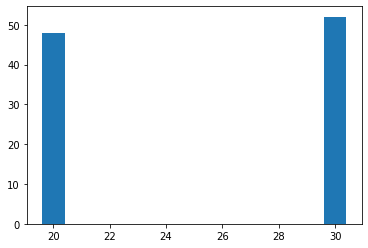

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

results = [my_random_function() for i in range(100)]

counts = Counter(results)
plt.bar(counts.keys(), counts.values())
plt.show()

If we provide a different coin probability, the result distribution will be different as well:

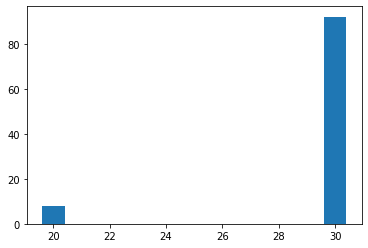

In [5]:
results = [my_random_function(0.1) for i in range(100)]

counts = Counter(results)
plt.bar(counts.keys(), counts.values())
plt.show()

Note that while the function returns `y`, which is randomly distributed,
the actual sampling happens when we flip the coin, so we might want to say that `heads` is the actual random variable an `y` is just a deterministic transformation of it.
However, since the only thing we can do with `my_random_function` is to execute it, we can't directly look at the distribution of `heads`.
Let's change this by "recording" the value of `heads` every time we call `my_random_function`.

We write a little helper function called `sample` that use to record the values we sampled for random variables.
Just like we can use `print` to print any value as a side effect, we can use `sample` to record a random variable as a side effect.
We store the RV values in a dictionary.

In [6]:
rv_dict = dict()

def clear_rvs():
    global rv_dict
    rv_dict = dict()

def sample(name, value):
    rv_dict[name] = value
    return value

Now we adapt `my_random_function` to use `sample` to record the value of `heads`:

In [7]:
def my_random_function(p=0.5):
    x = 10
    heads = sample("heads", random.random() < p)
    y = x*2 if heads else x*3
    return y

clear_rvs()
result = my_random_function()
print(result)
print(rv_dict)

30
{'heads': False}


As you can see, after running `my_random_function` again, the value of `heads` is recorded in `rv_dict` and the return value of `my_random_function` corresponds to the recorded value of heads.

What if we want to record several RVs? We can do that too:

In [8]:
def flip_two_coins(p1=0.5, p2=0.5):
    coin1 = sample("coin1", random.random() < p1)
    coin2 = sample("coin2", random.random() < p2)

results = []
for i in range(100):
    clear_rvs()              # clear the recorded values
    flip_two_coins(0.2, 0.6) # record new values 
    results.append((rv_dict["coin1"], rv_dict["coin2"]))
    
counts = Counter(results)
counts
#plt.bar(counts.keys(), counts.values())

Counter({(False, False): 37,
         (False, True): 41,
         (True, False): 9,
         (True, True): 13})

Note that creating many samples from this distribution (as we do above) gives us an estimate of how the random variables are distributed.
In this case, we get the approximate frequency of every possible variable assignment, which converges to the true probability of every variable assignment when the number of samples goes to infinity.
Even in the continuous case we can get an estimate of the shape of the distribution by drawing many samples,
but we would have to draw many more samples (depending on the complexity of the shape) and the number of possible configurations grows exponentially with the number of variables, so just sampling is not always a good solution.

### Exercises

1. Let's go bayesian! Write a probabilistic program that flips a coin with probability $p$,
   but first samples the probability $p$ from a uniform distribution $\text{U}(0,1)$.
   Note how this defines a joint distribution over the parameter $p$ and the result of the coin.
1. Extend your program to flip not just 1 coin but 100, each with probability $p$.
   Make sure that each flipped coin is a recorded as a random variable.
   How would you write the probability distribution for the sequence of coin flips mathematically?
1. Write a more complex program that simulates how a chord is constructed from a profile.
   First, sample the type of the chord $t$ from a categorical distribution over chord types.
   Then sample a number of notes $n$ from a poisson distribution (add 1 to the value to avoid 0s).
   Finally sample $n$ notes from a multinomial distribution with the weights that correspond to $h$.
   The parameters (weights for $h$, rate for $n$ and weights for the notes for each $h$) are given as arguments to the function.
1. Extend the previous program to also sample the parameters from a prior distribution.
   (Hint: use Dirichlet priors for the weight vectors and a Gamma prior for the rate of the Poisson distribution)
1. Extend the previous program to sample a flexible number of chords (provided as an argument).

## 3. Probabilistic Programming 2: Evaluating Probabilities

#### Summary

- We want to be able to evaluate the probability of a given sample from the joint distribution.
- We do that by introducing two new things:
  - Random values are drawn from `Distribution`s which can
    - generate a new random value and
    - evaluate the probability of a given value.
  - The `sample` function gets an additional interpretation that
    - returns the given value of the RV and
    - tracks that values local probability under the given distribution.
- The joint probability of the sample is the product of all local probabilities.
  - The local probabilities are conditional distributions
  - The probabilistic program defines a factorization of the joint distribution into local conditional distributions.
- Any probabilistic program written using `sample` and `Distributions` can be used to
  - draw a sample
  - evaluate the probability of a given sample
  - despite containing arbitrary Python code with unknown control flow.
- Drawing and evaluating samples is sufficient for inference.

So far, we have defined a probability distribution implicitly as a program that produces samples from the distribution.
We have also seen that by sampling a lot from this distribution, we can estimate it's shape.
While this is already useful, it's not quite enough to make serious inference, especially for more complex models.
There is one more thing that we need: In addition to sampling from the distribution, we also need to be able to evaluate the probability of a given sample.
With these two things, we will be able to do pretty much everything we need for performing bayesian inference.
(If it's not clear to you why, don't worry, it will be explained later).

In their current form, our probabilistic programs are a bit too implicit to be used for evaluating the probability of a sample.
However, we have already introduced a bit of structure by requiring random variables to be registered with the `sample` function.
It turns out that if we add a tiny little bit more structure, we can do probability evaluation too,
without changing our programs too much.

The first thing we need to do is to combine the ability to *sample* a value for a RV with the ability to evaluate its *local probability*.
Consider how we sampled the value of our coin in the prevous part:

In [9]:
def flip_coin(p=0.5):
    sample("heads", random.random() < p)

clear_rvs()
flip_coin()
print(rv_dict)

{'heads': True}


Note that for the RV "heads" we know exactly from which distribution we sample it.
In this case, it's taken from a Bernoulli distribution.
Since we know how we sample "heads", we also know the probability of each possible value of "heads":
for `True` it's $p$ and for `False` it's $1-p$.

Let's make this connection a bit more formal.
We have an object (a probability distribution) that can do two things: provide a sample from it and evaluate the probability of a given sample.
In python, we can express this idea using a class with two methods.

In [10]:
# abstract base class for distributions
class Distribution:
    "Return a sample from the distribution."
    def sample():
        pass
    
    "Return the log probability of a given sample from the distribution."
    def log_p(value):
        pass

Note that the second method returns the log probability instead of the probability.
The reason for this is that probabilities sometimes get very small and can become 0 due to representation errors.
This doesn't happen so easily in log space,
and it's trivial to obtain the log probability when the normal probability is known (and vice versa).

We can now implement this class for the Bernoulli distribution that formalizes our coin flip.

In [11]:
class Bernoulli(Distribution):
    def __init__(self, p):
        self.p = p
    
    def sample(self):
        return random.random() < self.p
    
    def log_p(self, heads):
        return np.log(self.p if heads else 1-self.p)

coin = Bernoulli(0.4)
print(coin.sample())
print("p(True)  =", np.exp(coin.log_p(True)))
print("p(False) =", np.exp(coin.log_p(False)))

False
p(True)  = 0.4
p(False) = 0.6


Now that we have a way to express primitive distributions that can be used for both sampling and evaluating the log probability, we require our probabilistic programs to use them.
Let's change the definition of `sample` to take a distribution object and `.sample()` from it:

In [12]:
def sample(name, dist):
    value = dist.sample()
    rv_dict[name] = value
    return value

Of course, we also have to change our program to make use of the `Bernoulli` distribution and the new way `sample` works:

In [13]:
def flip_coin(p):
    sample("heads", Bernoulli(p))

clear_rvs()
flip_coin(0.4)
print(rv_dict)

{'heads': True}


Works like a charm.

We still can't make use of the `log_p` method to evaluate the probability of a value for "heads".
However, since we require using `sample` to track random variables, we already have access to the place where RVs and distributions meet.
We could in principle write a different `sample` function that doesn't actually sample and record a fresh value for some RV, but instead looks up the value from a table that we provide beforehand and records it's log probability under the distribution that is provided!

In [14]:
known_values = {}
recorded_probs = {}

def clear_recorded_probs():
    global recorded_probs
    recorded_probs = {}

# our reimplementation of sample that evaluates probabilities
def sample(name, dist):
    value = known_values[name]
    recorded_probs[name] = dist.log_p(value)
    return value

If we set `known_values` to contain values for all RVs and run our model again, we should now be able to obtain the local probabilities for each RV.

In [16]:
# run the model for 'heads' = True
known_values = {'heads': True}
clear_recorded_probs()
flip_coin(0.4)
print("p(heads = True)  =", np.exp(recorded_probs['heads']))

# run the model for 'heads' = False
known_values = {'heads': False}
clear_recorded_probs()
flip_coin(0.4)
print("p(heads = False) =", np.exp(recorded_probs['heads']))

p(heads = True)  = 0.4
p(heads = False) = 0.6


It's still a bit inconvenient that we have to redefine `sample` depending on whether we want to sample or to evaluate.
Ideally, we should be able to abstract over the interpretation of `sample`.
For example, we can make it look it's functionality up in a variable that we can change to "sample" or "evaluate" or some other actual interpretation.

In [17]:
sample_function = None

def sample(name, dist):
    return sample_function(name, dist)

# implementation of "sample" that samples and records a value (standard interpretation)
def sample_sample(name, dist):
    value = dist.sample()
    rv_dict[name] = value
    return value

# implementation of "sample" that returns the already know value for a RV and records its local probability
def sample_eval(name, dist):
    value = known_values[name]
    recorded_probs[name] = dist.log_p(value)
    return value

# we set sample_function to be sample_sample by default
sample_function = sample_sample

Now we can freely change the interpretation `sample` to draw samples or evaluate probabilities:

In [18]:
# draw a sample
clear_rvs()

sample_function = sample_sample
flip_coin(0.4)

print(rv_dict)

# evaluate a sample
known_values = {'heads': True}
clear_recorded_probs()

sample_function = sample_eval
flip_coin(0.4)

print(recorded_probs) #print the log probs for all RVs

{'heads': False}
{'heads': -0.916290731874155}


Let's try the same for a more complex model.
We flip two coins, but the probability of the second depends on the outcome of the first.
Fortunately, `sample_eval` returns the observed value for the first coin, the when running the model with observed values, it will choose the correct probability parameters for the second coin, just as if the value of the first coin would have been sampled randomly!

We can try this out by first drawing a sample and then evaluating the probability of that sample.

In [19]:
# our shiny two-coin model
def flip_two_coins():
    coin1 = sample('coin1', Bernoulli(0.5))
    coin2 = sample('coin2', Bernoulli(0.8 if coin1 else 0.2))

# draw a sample
clear_rvs()
sample_function = sample_sample
flip_two_coins()
print(rv_dict)

# evaluate the sample
clear_recorded_probs()
known_values = rv_dict # take the sample from the previous run
sample_function = sample_eval
flip_two_coins()
print({name: np.exp(prob) for (name,prob) in recorded_probs.items()})

{'coin1': False, 'coin2': False}
{'coin1': 0.5, 'coin2': 0.8}


Note how the probability of the second coin is evaluated correctly wrt. the first coin!
That's because when the model is run again, it picks the parameters for the second Bernoulli distribution according to the observed value of the first coin.
The second `sample` call therefore is given the Bernoulli distribution with the correct parameters and can evaluate the probability of the second coin's value correctly.

Congratulations, you have now implemented a probabilistic programming language!
We already have everything we need to sample from and evaluate samples under joint distributions that are defined as arbitrary Python programs.
As long as the actual random decisions are made using `sample` and from a `Distribution`, the remainder of the model can be arbitrary Python code.
In fact, `sample` and `Distribution`s are the only "language" constructs we needed to add to ordinary Python for writing models.
All the inference stuff can now be done outside of the models in a generic, model-independent way.

"But wait," you might object "we only computed the 'local probability' of each RV, not the joint probability of the whole assignment! And what is that 'local probability' even supposed to mean?"
It turns out that the local probablities are all we need to compute the joint probability of the assignment.
All we have to do is to multiply them (or rather sum the log probabilities and take the exponential).

In [20]:
def joint_log_p(rv_log_probs):
    return sum(rv_log_probs.values())

prob = np.exp(joint_log_p(recorded_probs))
print("p(coin1 =", rv_dict['coin1'], ", coin2 =", rv_dict['coin2'], ") = ", prob) 

p(coin1 = False , coin2 = False ) =  0.4


Why does this work?

Remember that any joint probability distribution can be turned into a generative process by factorizing it into a sequence of conditional distributions.
For example $p(A,B,C)$ can be factorized into $p(A) p(B \mid A) p(C \mid A, B)$,
which corresponds to a process that first samples $A$ then, $B$ given $A$, and finally $C$ given $A$ and $B$.

A probabilistic program is exactly such a factorization, corresponding to the order in which the RVs are sampled in the program.
For example, the model `flip_two_coins` first samples `coin1` from $p(\text{coin1})$ and then `coin2` from $p(\text{coin2} \mid \text{coin1})$,
and we know that $p(\text{coin1}) p(\text{coin2} \mid \text{coin1}) = p(\text{coin1}, \text{coin2})$.
Now we can see that the "local probability" of a RV actually is the *conditional probability* of that RV given all the RVs that were sampled before!

Note that a variable after another variable does not need to depend on that earlier variable.
For example, we might sample $A$, $B$, and $C$ in that order, but maybe $B$ is sampled from a distribution that is fixed and independent of $A$, so the distribution factorizes into $p(A) p(B) p(C \mid A,B)$.
However, if $A$ and $B$ are independent, then it holds that $p(B \mid A) = p(B)$,
so $p(A) p(B) p(C \mid A,B) = p(A) p(B \mid A) p(C \mid A,B)$!

Finally, the order need not be defined beforehand. Consider, for example the following model:

In [21]:
def weird_model():
    a = sample("A", Bernoulli(0.5))
    if a:
        b = sample("B", Bernoulli(0.3))
        c = sample("C", Bernoulli(0.2 if b else 0.6))
    else:
        c = sample("C", Bernoulli(0.4))
        b = sample("B", Bernoulli(0.1 if c else 0.2))

clear_rvs()
sample_function = sample_sample
weird_model()
print(rv_dict)

{'A': True, 'B': False, 'C': False}


In this model, the factorization depends on $A$.
If $A$ is `True`, then $B$ is sampled first and $C$ depends on $B$
$$ p(A = \text{True},B,C) = p(A = \text{True}) p(B \mid A = \text{True}) p(C \mid A = \text{True}, B) $$

If $A$ is `False`, it's the other way round.
$$ p(A = \text{False},B,C) = p(A = \text{False}) p(C \mid A = \text{False}) p(B \mid C, A = \text{False}) $$

Since we only want to evaluate complete assignments, it's sufficient to know that the "local" probabilities are *a* factorization of the joint distribution.

### Exercises

tbd.

## 4. Inference

#### Summary

- we want to know $p(Z \mid X=x)$ 
  - can't be derived analytically
  - we could sample, but it's expensive
- approximation
  - choose a variational familiy ("guide" in pyro) $q_\phi(Z)$
  - try to optimize $\phi$ to minimize $\text{KL}(q(Z) \parallel p(Z \mid X=x))$
  - we can't compute the KL directly, but we can optimize it via the equivalent "ELBO".
  - the mean-field family is often a good choice for the guide.

In the previous sections we have learned how we can write probabilistic programs in a way that allows us to (a) sample from the joint distribution and (b) evaluate the probability of a sample (i.e. a full variable assingment).
But how do we obtain the posterior distribution when conditioning on observations of some RVs, i.e. $p(Z \mid X=x)$?

### Sampling

First let's note that while we can use our probabilistic program to sample from the joint distribution, we can't use it directly to sample from the posterior distribution.
A naive attempt at doing so could be to add a new implementation of `sample`
- samples unobserved RVs normally, and
- returns the observed value for observed variables.

However, this would not sample from the conditional distribution.
To see why, consider the following program:

In [22]:
def simple_coins():
    c1 = sample("c1", Bernoulli(0.5))
    c2 = sample("c2", Bernoulli(0.9 if c1 else 0.1))

If we observe that $c_2$ is heads, what do you think $c_1$ was?
It's more likely that $c_1$ was heads (`True`) than tails (`False`) since heads for $c_1$ makes heads for $c_2$ much more likely.
We can even quantify the distribution $p(c_1 \mid c_2 = \text{heads})$ exactly using Bayes' formula:
$$
  p(c_1 \mid c_2 = \text{heads}) = \dfrac{p(c_2 = \text{heads} \mid c_1) p(c_1)}{p(c_2 = \text{heads})}\\
  p(c_1 = \text{heads} \mid c_2 = \text{heads}) = \dfrac{p(c_2 = \text{heads} \mid c_1 = \text{heads}) p(c_1 = \text{heads})}{p(c_2 = \text{heads})} = \dfrac{0.9 \cdot 0.5}{0.5 \cdot 0.9 + 0.5 \cdot 0.1} = 0.9\\
  p(c_1 = \text{tails} \mid c_2 = \text{heads}) = \dfrac{p(c_2 = \text{heads} \mid c_1 = \text{tails}) p(c_1 = \text{tails})}{p(c_2 = \text{heads})} = \dfrac{0.1 \cdot 0.5}{0.5 \cdot 0.9 + 0.5 \cdot 0.1} = 0.1\\
$$
But imagine we would sample from `simple_coins` as described above, simply fixing "c2" to be heads.
We would still sample $c_1$ from $\text{Bernoulli}(0.5)$, although $c_1 \mid (c_2 = \text{heads}) \sim \text{Bernoulli}(0.9)$!
Generally, there is a difference between "intervention" (simply fixing the values of the observed RVs without touching the others) and "conditioning" (changing the distribution of the unobserved variables to reflect the conditional distribution).

However, there are other methods by which we can use a program like `simple_coins` to sample from the posterior distribution.
The most simple and universal one is called *rejection sampling*.
It draws normal samples from joint distribution, but since we are only interested in the cases where some "condition" holds (e.g. that $c_2 = \text{heads}$), it "rejects" all samples where the condition is not true.
This is as simple to implement as it sounds:

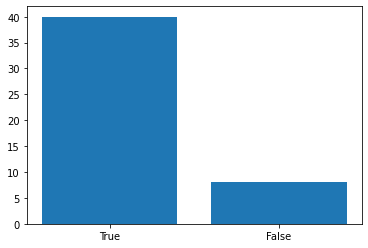

Counter({True: 40, False: 8})
48


In [31]:
sample_function = sample_sample
n = 100
samples_c1 = []

# draw n samples
for _ in range(n):
    clear_rvs()
    # draw the sample
    simple_coins()
    # check if the condition is satisfied
    if rv_dict["c2"] == True:
        # record the value of c1
        samples_c1.append(rv_dict["c1"])

# count and plot the outcome
counts_c1 = Counter(samples_c1)
plt.bar([str(k) for k in counts_c1.keys()], counts_c1.values())
plt.show()
print(counts_c1)
print(len(samples_c1))

As you can see, the samples of $c_1$ are distributed roughly according to the posterior distribution (with $p=0.9$ rather than $0.5$).
But you probably have also noticed, that we have to throw away roughly half of our samples
since the condition is only satisfied with probability 0.5!
As you can imagine, if the probability of the condition becomes less likely, rejection sampling becomes rather inefficient.
For example, our condition is normally the observation of a large dataset,
and the probability of the condition is the probability to generate exactly that dataset from the model by chance!

There are smarter ways of sampling from the conditional distribution such as [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) sampling,
which requires the ability to evaluate the probability of a sample (which we know how to do).
However, sampling methods have some general disadvantages,
for example that they don't provide us with a closed formula for (an approximation of) the posterior,
unless combined with other methods such as kernel-density estimation.
Therefore, we will now focus on a different method called "variational inference".
It is, however, important to note that our way of defining probabilistic programs using `sample` is in principle sufficient to use advanced sampling algorithms on arbitrary models.

### Variational Inference

(This section is basically a short summary of [Blei et al., 2017](https://www.tandfonline.com/doi/full/10.1080/01621459.2017.1285773))

Remember that our goal is to determine the posterior distribution $p(Z \mid X=x)$.
While the posterior distribution can in principle be obtained via Bayes' formula,
it requires to compute the normalization factor $p(X=x)$ (the "evidence"),
which doesn't always have a closed form.

Variational inference is based on the idea that instead of computing the posterior $p(Z \mid X=x)$ directly, we *approximate* it by a different distribution $q(Z)$.
We can do this by choosing a *familiy* of distributions $q_\phi(Z)$,
for which we try to find the optimal parameters $\phi$ so that $q_\phi(Z)$ is as similar to $p(Z \mid X=x)$ as possible.
What does "similar" mean?
Since we talk about the similarity of distributions, a useful measure is the Kullback-Leibler divergence,
which measures the "expected" difference of one distribution from another distribution:

$$
    \text{KL}(p_1 \parallel p_2)
    = \sum_x p_1(X=x) \log \left( \dfrac{p_1(X=x)}{p_2(X=x)} \right)
    = \mathbf{E}_{p_1}[\log p_1(X)] - \mathbf{E}_{p_1}[\log p_2(X)].
$$

Note that the KL divergence is not symmetric, since the expected value is taken with respect to $p_1$!

If we apply the KL divergence to the variational distribution $q_\phi(Z)$ and the posterior $p(Z \mid X=x)$,
we get

$$
    \text{KL}(q_\phi(Z) \parallel p(Z \mid X=x)) = \mathbf{E}_{q_\phi}[\log q_\phi(Z)] - \mathbf{E}_{q_\phi}[\log p(Z \mid X=x)]
$$

Finding the best $\phi$ now amounts to minimizing the KL divergence as stated above, so we have an objective function for optimizing $\phi$!
The problem is that we can't evaluate this objective function since we can't evaluate $p(Z \mid X=x)$;
our probabilistic programs only allow us to evaluate probabilities wrt. the joint distribution $p(X,Z)$.
However, remember that we can rewrite $p(Z \mid X=x)$ as
$\dfrac{p(X=x, Z)}{p(X=x)}.$
The numerator is given by the joint distribution, so we can evaluate it.
The denominator is the "evidence"; we can't evaluate it (which creates the whole problem in the first place), but we know that, for a given $x$, $p(X=x)$ is constant, and constants are irrelevant to an optimiziation objective.

Let's apply this insight to our objective function:

$$
\begin{align*}
    \text{KL}(q_\phi(Z) \parallel p(Z \mid X=x))
    &= \mathbf{E}_{q_\phi}[\log q_\phi(Z)] - \mathbf{E}_{q_\phi}[\log p(X=x, Z) - \log p(X=x)]\\
    &= \mathbf{E}_{q_\phi}[\log q_\phi(Z)] - \mathbf{E}_{q_\phi}[\log p(X=x,Z)] + \log p(X=x).
\end{align*}
$$

Since the term $\log p(X=x)$ is constant, we can ignore it for optimization and define the "ELBO" as:

$$
\begin{align*}
    \text{ELBO}(q_\phi) &= \log p(X=x) - \text{KL}(q(Z) \parallel p(Z \mid X=x))\\
    &= \mathbf{E}_{q_\phi}[\log p(X=x,Z)] - \mathbf{E}_{q_\phi}[\log q_\phi(Z)].
\end{align*}
$$

Note the change of sign: Instead of minimizing the KL divergence, we maximize the the ELBO, but the optimal parameters $\phi$ are the same for both.
ELBO stands for "evidence lower bound", because it is a lower bound to the log evidence $\log p(X=x)$,
as we can see from the equation above.
If $q_\phi$ and the posterior distribution are the same,
then the KL divergence is 0 and  $\text{ELBO}(q_\phi) = \log p(X=x)$.
If $q_\phi$ is an imperfect approximation of the posterior,
then the KL divergence is positive and $\text{ELBO}(q_\phi) < \log p(X=x)$,
so generally

$$
    \text{ELBO}(q_\phi) \leq \log p(X=x).
$$

Note that the ELBO requires us to compute expected values wrt. $q_\phi$.
While this may be intractable (because we have to sum/integrate over $Z$),
we can estimate these expectation by drawing samples of $Z$ from $q_\phi$.
Fortunately, we already know how express distributions that we can sample from,
namely as probabilistic programs.
We don't know yet how to optimize them, but that's the topic of the next section.

The question remains how we choose the family $q_\phi$.
It needs to be flexible enough to allow for good approximations of the posterior while being simple enough to be optimized efficiently.
A common strategy is to use a *mean-field* family, which treats each latent variable as independent.
This family is easy to optimize and can capture any marginal distribution of individual variables,
but it can't express correlations between latent variables.
However, since we are often interested in the marginal posteriors of individual latent variables (e.g. to asses the certainty about an inferred parameter of our model), the mean-field family is very useful.

In general, we can write the mean-field family as

$$
    q(Z) = \prod_i q_i(Z_i),
$$

where each $q_i$ comes with its own parameters.
We then choose a plausible $q_i$ for each latent variable $Z_i$.
If you don't know anything else, the family of the variables conjugate prior is a good choice,
but in principle any distribution with the same support as $Z_i$ works.

### Examples

Let's look at some concrete examples now.
First, we go back to our problem above, where we tried to infer the outcome of the first coin flip from the second.
As a reminder, here is our model again:

In [32]:
def simple_coins():
    c1 = sample("c1", Bernoulli(0.5))
    c2 = sample("c2", Bernoulli(0.9 if c1 else 0.1))

So how do we choose our variational family $q_\phi$?
First of all, we know that it only concerns one variable, namely $c_1$, which is a binary variable.
We also know that every possible distribution over a single binary varible is a Bernoulli distribution.
Therefore, we know that the posterior $p(c_1 \mid c_2)$ must also be a Bernoulli distribution,
so the Bernoulli family is our best choice for $q_\phi$, with $\phi$ being the Bernoulli parameter.

Since $q_\phi$ is a family of distributions, we can now express it as a probabilistic program that takes some parameters ($\phi$).
Everytime we call this program with certain parameters, it describes a distribution, a member of the family $q_\phi$.
In pyro, the variational family is called *guide*, so we are going to follow this convention.

In [33]:
def simple_coins_guide(phi):
    sample("c1", Bernoulli(phi))

Note how we `sample` $c_1$ just as we do in `simple_coins`.
That's because we want to express that the RVs of the guide are the same as the unobserved variables of the model.
The goal is now to find a `phi` that optimizes then ELBO between `simple_coins_guide` and the posterior of `simple_coins`.
How we can do that will be the topic of the next section.

Now let's look at another, slightly more complex example.
Imagine that instead of assuming a fixed probability $\theta$ for the first coin,
we would like to infer the probability from observations.
As we have learned in the first sections, this means including the probability into our model as a random varibale and define a joint distribution over $\theta$, $c_1$, and $c_2$.
The model `simple_coins` already tells us how to sample $c_1, c_2 \mid \theta$, so all we need is a prior for $\theta$.
We are going to go with the [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) for $\theta$, which is conjugate prior to the Bernoulli distribution in which $\theta$ is used.
Instead of defining this distribution ourselves (which we could do!), we are going to take it from `pyro.distributions`.

In [35]:
from pyro.distributions import Beta

def complicated_coins():
    theta = sample("theta", Beta(1,1)) # this is just a uniform distribution between 0 and 1
    c1 = sample("c1", Bernoulli(theta))
    c2 = sample("c2", Bernoulli(0.9 if c1 else 0.1))

clear_rvs()
sample_function = sample_sample
complicated_coins()
rv_dict

{'theta': tensor(0.0249), 'c1': tensor(False), 'c2': False}

Huh! For some reason, using the Beta distribution from pyro makes our random values become some kind of `tensor` thing (at least some of them).
We will figure out why in the next section, but for now we can ignore it.

Now it's very difficult to obtain a reliable estimate of $\theta$ from a single observation of $c_2$.
In practice, we would have a whole dataset of observations that we can use to infer a parameter that underlies all of them.
In this case, for example, we could flip $c_1$ and $c_2$ several times, assuming that the fairness of $c_1$ stays the same.
Let's include this idea into our model:

In [36]:
def complicated_coins(n):
    # sample theta once
    theta = sample("theta", Beta(1,1))
    for i in range(n):
        c1 = sample("c1_{}".format(i), Bernoulli(theta))
        c2 = sample("c2_{}".format(i), Bernoulli(0.9 if c1 else 0.1))

clear_rvs()
sample_function = sample_sample
complicated_coins(3)
rv_dict

{'theta': tensor(0.8411),
 'c1_0': tensor(False),
 'c2_0': False,
 'c1_1': tensor(True),
 'c2_1': False,
 'c1_2': tensor(False),
 'c2_2': False}

In this version of `complicated_coins` we can provide an additional parameter `n` that tells us how many coin pairs we flip.
Since we want to be able to distinguish the outcomes of each pair, we add an index to `c1` and `c2` indicating the trial.

Now to the guide.
Since we only want to observe the $c_2$s, we need to provide a guide for both $\theta$ and the $c_1$ of each trial.
For the $c_1$s we already know that we want a Bernoulli distribution,
and for $\theta$ we again choose a beta distribution, which has two parameters $\alpha$ and $\beta$.
According to the mean-field strategy,
we assume the $c_1$s and $\theta$ to be independent in the posterior, so the guide is

$$
    q_\phi(\vec{c_1}, \theta) = p(\theta ;  \alpha, \beta) \prod_i p(c_{1i} ; \varphi_i),
$$

and $\phi = (\alpha, \beta, \vec{\varphi})$.

This is easy enough to write as a program:

In [38]:
def complicated_coins_guide(n, alpha, beta, c1probs):
    sample("theta", Beta(alpha, beta))
    for i in range(n):
        sample("c1_{}".format(i), Bernoulli(c1probs[i]))

One thing that is not so nice is that the number of samples and the parameters of the family both appear as function parameters.
While `n` is just used to make the model adaptable to the size of the dataset,
`alpha`, `beta`, and `c1probs` are parameters that we want to optimize.
To make this explicit (and to allow automatic optimization, which will be discussed later),
pyro provides another function called `param`, which takes a parameter name and a starting value.
It registers the parameter in a parameter store similar to how `sample` registers random variables.
We can rewrite our guide to a form that matches the one used in pyro.

In [40]:
def params(name, initial_value):
    return initial_value # does nothing interesting for now

def complicated_coins_guide(n):
    # params and distribution for theta
    alpha = param("alpha", 1.)
    beta  = param("beta",  1.)
    sample("theta", Beta(alpha, beta))
    # params and distribution for c1
    c1probs = param("c1probs", [.5 for _ in n])
    for i in range(n):
        sample("c1_{}".format(i), Bernoulli(c1probs[i]))

Note how `complicated_coins_guide` now has the same signature as `complicated_coins`.
This makes it easy to ensure that we always generate the same model structure (e.g. the same number of coin flips) in the model and the guide, by defining their arguments once and passing these arguments to both functions.

The only thing that is missing now is how `param` works and how we can use it to optimize the parameters of the guide.
This will be the topic of the last two sections.

#### Exercises

tbd.

## 5. Optimization via PyTorch

- tensors
- autodiff
- backprop
- optimizers

In [1]:
import torch

In [5]:
x = torch.tensor(1.)

In [19]:
def f(x):
    return 0.5 * x**2 + 1.

In [20]:
y = f(x)
y

tensor(1.5000)

In [25]:
x.requires_grad = True
y = f(x)
y.backward()

In [28]:
x.grad

tensor(1.)

In [37]:
# gradient descent
lr = 0.1
x = torch.tensor(1., requires_grad=True)
for i in range(100):
    y = f(x)
    y.backward()
    print('gradient = ', x.grad)
    x.data -= lr * x.grad
    print('x = ', x.data)
    x.grad.data.zero_()

gradient =  tensor(1.)
x =  tensor(0.9000)
gradient =  tensor(0.9000)
x =  tensor(0.8100)
gradient =  tensor(0.8100)
x =  tensor(0.7290)
gradient =  tensor(0.7290)
x =  tensor(0.6561)
gradient =  tensor(0.6561)
x =  tensor(0.5905)
gradient =  tensor(0.5905)
x =  tensor(0.5314)
gradient =  tensor(0.5314)
x =  tensor(0.4783)
gradient =  tensor(0.4783)
x =  tensor(0.4305)
gradient =  tensor(0.4305)
x =  tensor(0.3874)
gradient =  tensor(0.3874)
x =  tensor(0.3487)
gradient =  tensor(0.3487)
x =  tensor(0.3138)
gradient =  tensor(0.3138)
x =  tensor(0.2824)
gradient =  tensor(0.2824)
x =  tensor(0.2542)
gradient =  tensor(0.2542)
x =  tensor(0.2288)
gradient =  tensor(0.2288)
x =  tensor(0.2059)
gradient =  tensor(0.2059)
x =  tensor(0.1853)
gradient =  tensor(0.1853)
x =  tensor(0.1668)
gradient =  tensor(0.1668)
x =  tensor(0.1501)
gradient =  tensor(0.1501)
x =  tensor(0.1351)
gradient =  tensor(0.1351)
x =  tensor(0.1216)
gradient =  tensor(0.1216)
x =  tensor(0.1094)
gradient =  tenso

In [184]:
dist = Bernoulli(torch.tensor(0.4, requires_grad=True))
lp = dist.log_p(True)
lp

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

## 6. Lighting the Whole Thing Up

- torch + "sample" + distributions = pyro